# Popular Topics in Data Science

The objective for this project is to identify relevant and high-impact topics for a company that creates educational content in the field of data science. To accomplish our mission, we will need to access current data about topics the target customer finds most interesting.

Fortunately, [Stack Exchange](https://stackexchange.com/) hosts dedicated Q&A communities, where users can collaborate and learn about a multitude of topics from mathematics and physics to photography and homebrewing. They can pose questions to the community, provide assistance to others and discuss a wide range of topics. Additionaly, a reputational award system allows users to upvote or downvote submissions, helping to identify the most informative posts.

For this project, we will explore data from posts to the [Data Science Stack Exchange (DSSE)](https://datascience.stackexchange.com/). To obtain the necessary data, we will utilize the [Stack Exchange Data Explorer (SEDE)](https://data.stackexchange.com/datascience/query/new). The SEDE provides us with the capability to write SQL queries, enabling us to extract data, analyze trends and formulate insights to identify the most relevant topics.

---

# Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Explore Data

The [SEDE](https://data.stackexchange.com/datascience/query/new) contains a wealth of data on current topics in Data Science. We will run several queries to explore the database and select the most relevant information.

A select portion of the database schema is pictured below:

![Schema](schema.png)

---

The Schema contains several datapoints that are relevant to our objective:

- `Id`: Unique identifier for each post
- `PostTypeId`: Numeric categorical variable to identify questions, answers, etc.
- `CreationDate`: Date and time the post was created
- `Score`: The post's score
- `ViewCount`: Number of times the post was viewed
- `Tags`: List of tags applied to identify subject of post
- `AnswerCount`: Number of answers received (Only applicable to question posts.)
- `FavoriteCount`: Number of times the question was favored


It is evident that the `Tags` variable will be particularily important in identifying popular topics in Data Science.


---


## Tags

When a user submits a question to Stack Exchange, they can select up to five tags that are relevant to their post. The following query retrieves the 25 most frequently used tags on DSSE. By joining the `Tags` and `Posts` tables, we can also extract descriptions for proper tag usage. 

```SQL
SELECT TOP 25 
       t.Id,
       t.TagName,
       t.Count,
       p.Body AS Excerpt
  FROM Tags t
  JOIN Posts p ON p.Id = t.ExcerptPostId
 ORDER BY t.Count DESC;
```
 
The `tag_query_results.csv` file contains the results of this query.

In [3]:
top_tags = pd.read_csv("tag_query_results.csv")

top_tags

,Id,TagName,Count,Excerpt
0,2,machine-learning,11370,Machine Learning is a subfield of computer sci...
1,46,python,6681,Use for data science questions related to the ...
2,194,deep-learning,4859,a new area of Machine Learning research concer...
3,81,neural-network,4361,"Artificial neural networks (ANN), are composed..."
4,77,classification,3265,An instance of supervised learning that identi...
5,324,keras,2721,"Keras is a popular, open-source deep learning ..."
6,47,nlp,2714,Natural language processing (NLP) is a field o...
7,128,scikit-learn,2303,scikit-learn is a popular machine learning pac...
8,321,tensorflow,2185,TensorFlow is an open source library for machi...
9,72,time-series,1870,Time series are data observed over time (eithe...


While we have identified the top 25 most frequently used tags, it is essential to obtain more granular information to determine the most relevant topics. In a rapidly evolving field like data science, tags that were popular several years ago may no longer be relevant. To ensure our analysis is relevant, we will focus on posts submitted to DSSE in 2023.

---

## Posts

The Posts table contains most of the key variables we are interested in, the following query will retrieve all of the posts submitted in 2023.

```SQL
SELECT p.Id, 
       p.PostTypeId, 
       pt.Name AS PostType,
       p.CreationDate, 
       p.Score, 
       p.ViewCount, 
       p.Tags, 
       p.AnswerCount, 
       p.FavoriteCount
       
  FROM Posts p
  LEFT JOIN PostTypes pt ON pt.ID = p.PostTypeId
 WHERE YEAR(CreationDate) = 2023;
 ```

The `posts_query_2023.csv` file contains the results of this query.

In [4]:
posts = pd.read_csv('posts_query_2023.csv', parse_dates=['CreationDate'])
posts.head()

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,<nlp><feature-selection><feature-engineering><...,1.0,NaN
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,<deep-learning><time-series><convolutional-neu...,1.0,NaN
2,117437,2,Answer,2023-01-01 12:04:00,0,NaN,NaN,NaN,NaN
3,117438,2,Answer,2023-01-01 12:33:00,0,NaN,NaN,NaN,NaN
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,<neural-network><keras><tensorflow><convolutio...,0.0,NaN


Our observations from the first 5 records are as follows:

- The dataset contains Question and Answer posts.
- Question posts contain data for more variables.
- Answer posts contain more null values.
- Answer posts may not have any tags associated with them.

Let's dig a little deeper to see if these observations hold true.

In [5]:
# Examine value counts for PostType

posts['PostType'].value_counts()

Question          3306
Answer            2315
TagWiki              4
TagWikiExcerpt       4
Name: PostType, dtype: int64

In [6]:
# Review the contents of Tag & ViewCount Columns for Answer Posts

answers = posts[posts['PostType'] == 'Answer']

print('Tag Value Counts:')
print(answers['Tags'].value_counts(dropna=False))
print('\n')
print('ViewCount Value Counts:')
print(answers['ViewCount'].value_counts(dropna=False))

Tag Value Counts:
NaN    2315
Name: Tags, dtype: int64


ViewCount Value Counts:
NaN    2315
Name: ViewCount, dtype: int64


Further analysis indicates there are additional `PostTypes` in the dataset, but their quantity is insignificant. Additionally, answer posts do not contain any data for `Tags` or `ViewCount`, which are key variables. Therefore, we will exclude answer posts from our study going forward. We will focus our study on the 3,306 questions posted to DSSE in 2023.

---

# Clean & Transform Data

- Select questions posted in 2023 as the dataset
- Clean `Tags` columns
- Drop the FavoriteCount Column




In [8]:
# Select Question Posts

quest_post = posts[posts['PostType']=='Question'].copy()
quest_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 0 to 5627
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             3306 non-null   int64         
 1   PostTypeId     3306 non-null   int64         
 2   PostType       3306 non-null   object        
 3   CreationDate   3306 non-null   datetime64[ns]
 4   Score          3306 non-null   int64         
 5   ViewCount      3306 non-null   float64       
 6   Tags           3306 non-null   object        
 7   AnswerCount    3306 non-null   float64       
 8   FavoriteCount  0 non-null      float64       
 9   MonthYear      3306 non-null   period[M]     
dtypes: datetime64[ns](1), float64(3), int64(3), object(2), period[M](1)
memory usage: 284.1+ KB


In [9]:
# Define a function to clean the Tags Column

def clean_split_tags(df,column_name):
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].str.replace("^<|>$", "", regex=True).str.split("><")
    return df_copy

# Apply the function

clean_quest_2023 = clean_split_tags(quest_post,'Tags')
clean_quest_2023.head(3)

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,MonthYear
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,"[nlp, feature-selection, feature-engineering, ...",1.0,NaN,2023-01
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,"[deep-learning, time-series, convolutional-neu...",1.0,NaN,2023-01
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,"[neural-network, keras, tensorflow, convolutio...",0.0,NaN,2023-01


In [10]:
# Clean the Tags Column

# quest_post['Tags'] = quest_post['Tags'].str.replace("^<|>$", "",regex=True).str.split("><")

In [11]:
# quest_post.head(3)

In [12]:
# Drop Favorite Count Column

clean_quest_2023 = clean_quest_2023.drop(columns=['FavoriteCount'])

In [13]:
clean_quest_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 0 to 5627
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            3306 non-null   int64         
 1   PostTypeId    3306 non-null   int64         
 2   PostType      3306 non-null   object        
 3   CreationDate  3306 non-null   datetime64[ns]
 4   Score         3306 non-null   int64         
 5   ViewCount     3306 non-null   float64       
 6   Tags          3306 non-null   object        
 7   AnswerCount   3306 non-null   float64       
 8   MonthYear     3306 non-null   period[M]     
dtypes: datetime64[ns](1), float64(2), int64(3), object(2), period[M](1)
memory usage: 258.3+ KB


# Analyze Data

In [14]:
# Top 20 Tags Used in 2023

tag_count = dict()

for tags in clean_quest_2023['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

tag_count = pd.DataFrame.from_dict(tag_count,orient='index')
tag_count.rename(columns={0:'Count'},inplace=True)
tag_count.sort_values(by='Count',ascending=False,inplace=True)
top_tags_2023 = tag_count.head(20)
print(top_tags_2023)

                        Count
machine-learning          868
python                    481
deep-learning             422
nlp                       321
neural-network            268
time-series               255
classification            217
tensorflow                189
pytorch                   172
transformer               153
regression                150
scikit-learn              147
dataset                   147
keras                     146
machine-learning-model    124
lstm                      123
statistics                107
clustering                104
cnn                        98
data                       90


In [15]:
# Top 20 Tags Viewed in 2023 

tag_view_count = dict()

for index, row in clean_quest_2023.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']

tag_view_count=pd.DataFrame.from_dict(tag_view_count,orient='index')
tag_view_count.rename(columns={0:'ViewCount'},inplace=True)
tag_view_count.sort_values(by='ViewCount',ascending=False,inplace=True)
top_views_2023 = tag_view_count.head(20)
print(top_views_2023)

                              ViewCount
nlp                            107003.0
machine-learning               104005.0
gpt                             82011.0
python                          72796.0
transformer                     64475.0
language-model                  49146.0
pytorch                         47557.0
deep-learning                   44207.0
neural-network                  34563.0
chatbot                         28650.0
tensorflow                      23759.0
cnn                             20708.0
word-embeddings                 20315.0
keras                           20151.0
convolutional-neural-network    18927.0
tokenization                    18849.0
scikit-learn                    17839.0
classification                  16599.0
time-series                     16353.0
image-classification            15666.0


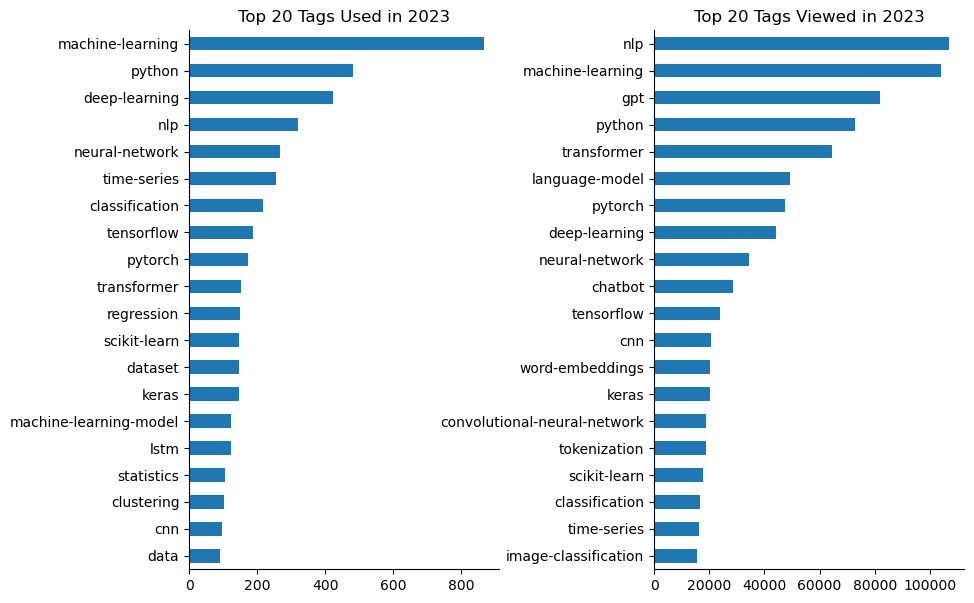

In [16]:
# Plot the Top 20 Tags Used and Viewed in 2023

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,7) )

top_tags_2023.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Tags Used in 2023')
axes[0].invert_yaxis()
axes[0].spines['top'].set_color('none')
axes[0].spines['right'].set_color('none')
axes[0].legend().remove()

top_views_2023.plot(kind='barh',ax=axes[1])
axes[1].set_title('Top 20 Tags Viewed in 2023')
axes[1].invert_yaxis()
axes[1].spines['top'].set_color('none')
axes[1].spines['right'].set_color('none')
axes[1].legend().remove()

plt.subplots_adjust(wspace=0.5)
plt.show()

In [17]:
# Construct a Co-occurrence Matrix
all_tags = list(tag_count.index)
tag_associations = pd.DataFrame(index=all_tags, columns=all_tags)
tag_associations.fillna(0,inplace=True)

# Count Co-occurrence of Tags in the Same Post
for tags in clean_quest_2023['Tags']:
    tag_associations.loc[tags,tags] += 1

# Set Diagonal Values to Zero
n = len(tag_associations)
indices = np.arange(n), np.arange(n)
tag_associations.values[indices] = 0

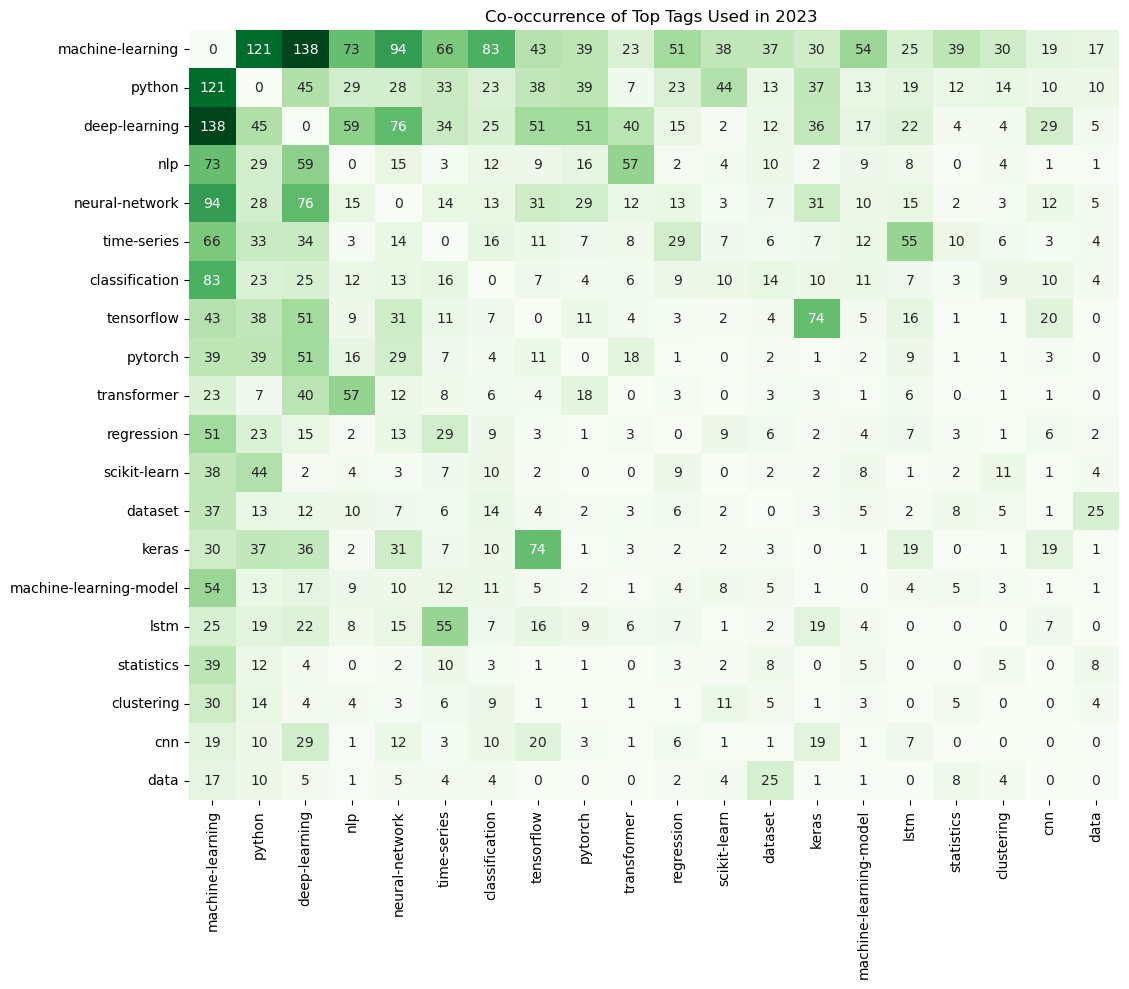

In [18]:
# Co-occurrence of Top Tags Used
used_list = list(top_tags_2023.index)

tag_relations_top_used = tag_associations.loc[used_list,used_list]

plt.figure(figsize=(12,10))
sns.heatmap(tag_relations_top_used,cmap='Greens',annot=True, fmt='d',cbar=False)
plt.title('Co-occurrence of Top Tags Used in 2023 ')
plt.show()

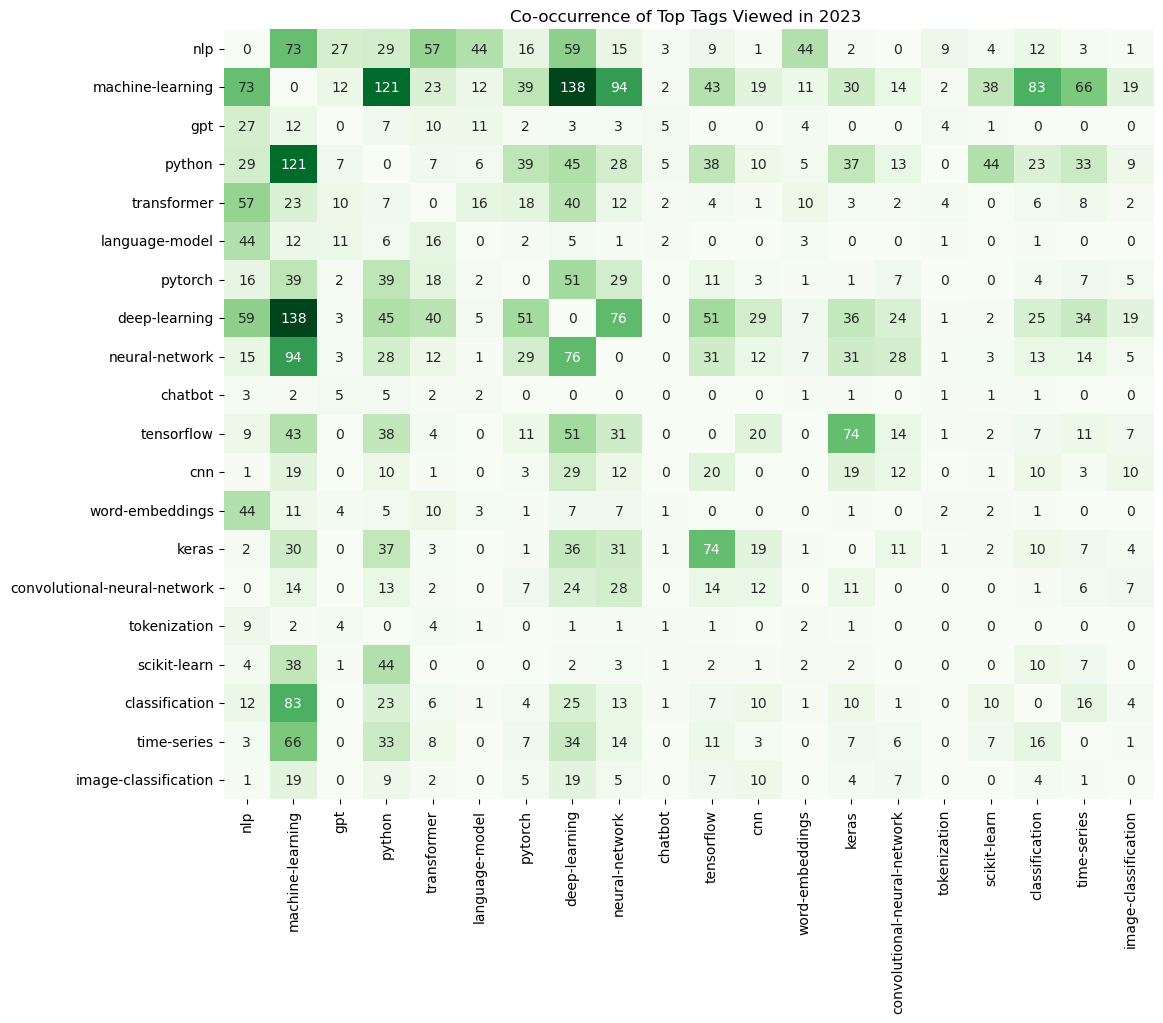

In [19]:
# Co-occurrence of Top Tags Viewed

viewed_list = list(top_views_2023.index)

tag_relations_top_viewed = tag_associations.loc[viewed_list,viewed_list]

plt.figure(figsize=(12,10))
sns.heatmap(tag_relations_top_viewed,cmap='Greens',annot=True, fmt='d',cbar=False)
plt.title('Co-occurrence of Top Tags Viewed in 2023 ')
plt.show()

In [20]:
# Compare the Differences between Top Tags Used and Top Tags Viewed

set_1 = set(top_tags_2023.index)
set_2 = set(top_views_2023.index)

# Find tags common between both sets
common_tags = set_1.intersection(set_2)

print("Top Tags in Both Categories:")
print(common_tags)

# Find tags present only in one list using set difference
tags_only_in_list_1 = set_1 - set_2
tags_only_in_list_2 = set_2 - set_1

# Print tags present only in one list
print("\nTags present only in Top Used Tags:")
print(tags_only_in_list_1)

print("\nTags present only in Top Viewed Tags:")
print(tags_only_in_list_2)


Top Tags in Both Categories:
{'scikit-learn', 'time-series', 'deep-learning', 'python', 'neural-network', 'pytorch', 'classification', 'tensorflow', 'keras', 'nlp', 'transformer', 'cnn', 'machine-learning'}

Tags present only in Top Used Tags:
{'dataset', 'regression', 'statistics', 'machine-learning-model', 'clustering', 'lstm', 'data'}

Tags present only in Top Viewed Tags:
{'image-classification', 'convolutional-neural-network', 'gpt', 'tokenization', 'language-model', 'chatbot', 'word-embeddings'}


In [21]:
# Top Viewed Tags Only

interesting_tags = list(tags_only_in_list_2)

tag_view_count.loc[interesting_tags].sort_values(by='ViewCount',ascending=False)

,ViewCount
gpt,82011.0
language-model,49146.0
chatbot,28650.0
word-embeddings,20315.0
convolutional-neural-network,18927.0
tokenization,18849.0
image-classification,15666.0


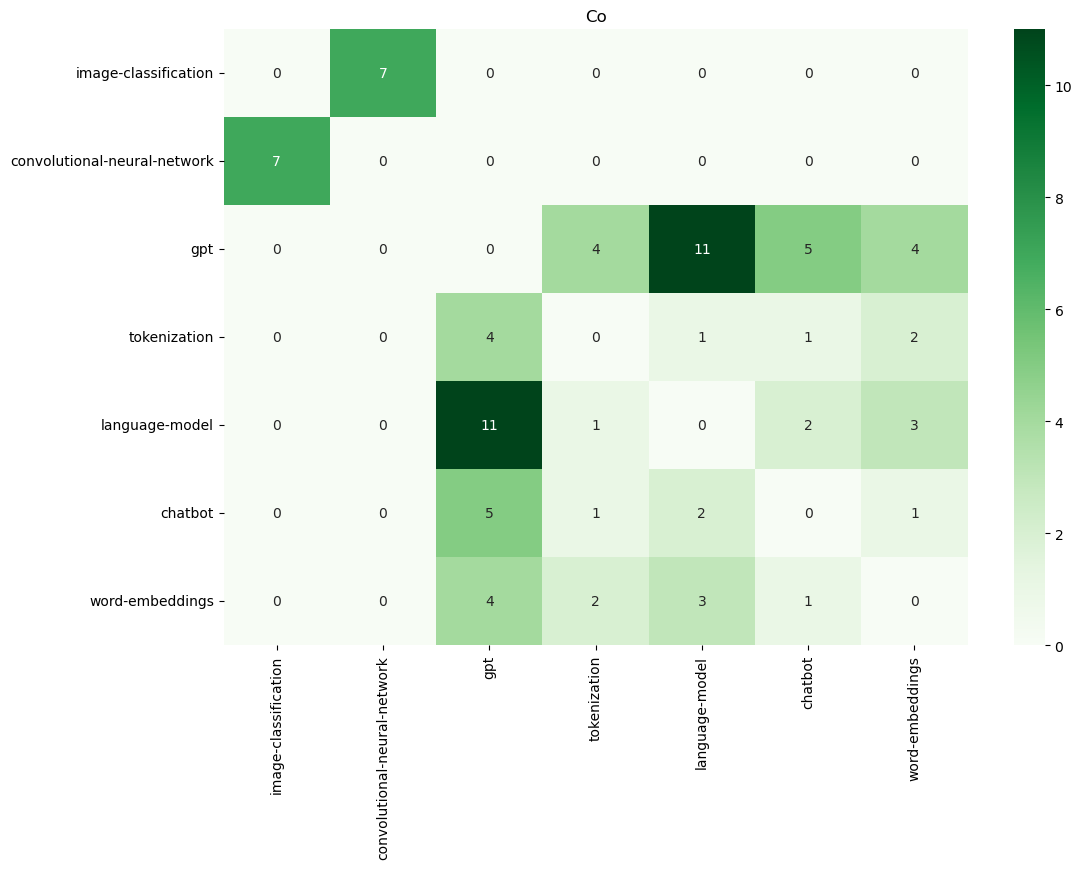

In [22]:
# View Co-occurrence of Interesting Tags 

interesting_tag_relations = tag_associations.loc[interesting_tags,interesting_tags]
plt.figure(figsize=(12,8))
sns.heatmap(interesting_tag_relations,cmap='Greens',annot=True, fmt='d')
plt.title('Co')
plt.show()


In [23]:
# The interesting tags can be classified in 2 groups: 
# Conversational AI and Computer Vision

In [24]:
clean_quest_2023.head()

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,MonthYear
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,"[nlp, feature-selection, feature-engineering, ...",1.0,2023-01
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,"[deep-learning, time-series, convolutional-neu...",1.0,2023-01
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,"[neural-network, keras, tensorflow, convolutio...",0.0,2023-01
6,117444,1,Question,2023-01-02 01:14:00,6,5805.0,"[nlp, gpu, language-model, memory]",1.0,2023-01
8,117447,1,Question,2023-01-02 05:52:00,1,74.0,"[python, pytorch, computer-vision, torchvision]",1.0,2023-01


In [25]:
def classify_tags(tags):
    conversational_ai_tags = ['gpt', 'language-model', 'chatbot', 'word-embeddings', 'tokenization']
    conversational_ai = 1 if any(tag in conversational_ai_tags for tag in tags) else 0
    return conversational_ai

clean_quest_2023['Conversational_AI'] = clean_quest_2023['Tags'].apply(lambda x: classify_tags(x))

In [26]:
clean_quest_2023

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,MonthYear,Conversational_AI
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,"[nlp, feature-selection, feature-engineering, ...",1.0,2023-01,0
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,"[deep-learning, time-series, convolutional-neu...",1.0,2023-01,0
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,"[neural-network, keras, tensorflow, convolutio...",0.0,2023-01,0
6,117444,1,Question,2023-01-02 01:14:00,6,5805.0,"[nlp, gpu, language-model, memory]",1.0,2023-01,1
8,117447,1,Question,2023-01-02 05:52:00,1,74.0,"[python, pytorch, computer-vision, torchvision]",1.0,2023-01,0
...,...,...,...,...,...,...,...,...,...,...
5622,126227,1,Question,2023-12-30 15:22:00,0,14.0,"[recommender-system, k-means, k-nn]",0.0,2023-12,0
5624,126230,1,Question,2023-12-30 19:37:00,0,34.0,"[machine-learning, neural-network, pytorch]",2.0,2023-12,0
5625,126232,1,Question,2023-12-30 23:20:00,0,36.0,[optimization],0.0,2023-12,0
5626,126234,1,Question,2023-12-31 07:21:00,0,10.0,"[machine-learning, algorithms, association-rules]",0.0,2023-12,0


In [27]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

clean_quest_2023["Quarter"] = clean_quest_2023["CreationDate"].apply(fetch_quarter)

clean_quest_2023

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,MonthYear,Conversational_AI,Quarter
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,"[nlp, feature-selection, feature-engineering, ...",1.0,2023-01,0,23Q1
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,"[deep-learning, time-series, convolutional-neu...",1.0,2023-01,0,23Q1
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,"[neural-network, keras, tensorflow, convolutio...",0.0,2023-01,0,23Q1
6,117444,1,Question,2023-01-02 01:14:00,6,5805.0,"[nlp, gpu, language-model, memory]",1.0,2023-01,1,23Q1
8,117447,1,Question,2023-01-02 05:52:00,1,74.0,"[python, pytorch, computer-vision, torchvision]",1.0,2023-01,0,23Q1
...,...,...,...,...,...,...,...,...,...,...,...
5622,126227,1,Question,2023-12-30 15:22:00,0,14.0,"[recommender-system, k-means, k-nn]",0.0,2023-12,0,23Q4
5624,126230,1,Question,2023-12-30 19:37:00,0,34.0,"[machine-learning, neural-network, pytorch]",2.0,2023-12,0,23Q4
5625,126232,1,Question,2023-12-30 23:20:00,0,36.0,[optimization],0.0,2023-12,0,23Q4
5626,126234,1,Question,2023-12-31 07:21:00,0,10.0,"[machine-learning, algorithms, association-rules]",0.0,2023-12,0,23Q4


In [28]:
quarterly = clean_quest_2023.groupby('Quarter').agg({"Conversational_AI": ['sum', 'size']})
quarterly.columns = ['conversational_ai_quest', 'total_quest']
quarterly["conversational_ai_quest_rate"] = quarterly["conversational_ai_quest"]\
                                /quarterly["total_quest"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)

quarterly


,Quarter,conversational_ai_quest,total_quest,conversational_ai_quest_rate
0,23Q1,62,890,0.069663
1,23Q2,62,945,0.065608
2,23Q3,35,765,0.045752
3,23Q4,40,706,0.056657


# Summarize Results

In [30]:
posts['MonthYear'] = posts['CreationDate'].dt.to_period('M')
posts

,Id,PostTypeId,PostType,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,MonthYear
0,117435,1,Question,2023-01-01 03:32:00,0,48.0,<nlp><feature-selection><feature-engineering><...,1.0,NaN,2023-01
1,117436,1,Question,2023-01-01 11:42:00,0,75.0,<deep-learning><time-series><convolutional-neu...,1.0,NaN,2023-01
2,117437,2,Answer,2023-01-01 12:04:00,0,NaN,NaN,NaN,NaN,2023-01
3,117438,2,Answer,2023-01-01 12:33:00,0,NaN,NaN,NaN,NaN,2023-01
4,117439,1,Question,2023-01-01 12:54:00,0,2051.0,<neural-network><keras><tensorflow><convolutio...,0.0,NaN,2023-01
...,...,...,...,...,...,...,...,...,...,...
5624,126230,1,Question,2023-12-30 19:37:00,0,34.0,<machine-learning><neural-network><pytorch>,2.0,NaN,2023-12
5625,126232,1,Question,2023-12-30 23:20:00,0,36.0,<optimization>,0.0,NaN,2023-12
5626,126234,1,Question,2023-12-31 07:21:00,0,10.0,<machine-learning><algorithms><association-rules>,0.0,NaN,2023-12
5627,126235,1,Question,2023-12-31 12:50:00,1,48.0,<time-series><forecasting>,1.0,NaN,2023-12
